In [1]:
import os
import glob
from datetime import datetime
from collections import defaultdict

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

from sklearn.metrics import confusion_matrix, balanced_accuracy_score, accuracy_score, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

def sigmoid(x, k, x0):
    return (1 / (1 + np.exp(-k * (x - x0))) - 1 / (1 + np.exp(-k * (0 - x0)))) / (1 / (1 + np.exp(-k * (1 - x0))) - 1 / (1 + np.exp(-k * (0 - x0))))


In [2]:
rrdp_dir = '../SAGE_RRDP/s_rrdp_v01_fv01'
rrdp_mask = '*_N_*.nc'
coll_dir = './collocated'

#rrdp_dir = '../SAGE_RRDP/s_rrdp_jan21'
#rrdp_mask = '*_N.nc'
#coll_dir = './collocated'

rrdp_files = sorted(glob.glob(os.path.join(rrdp_dir, rrdp_mask)))
rrdp_dates = [datetime.strptime(os.path.basename(f).split('_')[0], '%Y%m%d') for f in rrdp_files]
coll_files = [f'{coll_dir}/{d.strftime("%Y")}/lagrangian_{d.strftime("%Y%m%d")}.nc' for d in rrdp_dates]
rrdp_coll_date_files = [(date, rf, cf) for date, rf, cf in zip(rrdp_dates, rrdp_files, coll_files) if os.path.exists(cf)]
len(rrdp_coll_date_files), rrdp_coll_date_files[0]

(2688,
 (datetime.datetime(2012, 1, 2, 0, 0),
  '../SAGE_RRDP/s_rrdp_v01_fv01/20120102_N_v01_fv01.nc',
  './collocated/2012/lagrangian_20120102.nc'))

In [3]:
rrdp_icetypes = ['NIC_dom_icetype', 'autoDMI_dom_icetype', 'AARI_dom_icetype', 'CIS_dom_icetype']
lagr_algos = ['lm', 'newdc', 'nsidc']

data_for_plotting = None
probas = []
for date, rf, cf in tqdm(rrdp_coll_date_files):
    ice_type = {}
    with xr.open_dataset(rf) as ds:
        for rrdp_icetype in rrdp_icetypes:
            if rrdp_icetype in ds:
                ice_type[rrdp_icetype] = ds[rrdp_icetype][0].values
        
    with xr.open_dataset(cf) as ds:
        lm_myi = ds['lm_myi'][0].values / 100.0
        lm_fyi = ds['lm_fyi'][0].values / 100.0
        newdc_ice_type = ds['newdc_ice_type'][0].values
        nsidc_ice_type = ds['nsidc_ice_type'][0].values

    proba = {}
    proba['lm'] = np.stack([
        lm_fyi, lm_myi,
        #sigmoid(lm_fyi, k_fyi, x0_fyi),
        #sigmoid(lm_myi, k_myi, x0_myi),
    ], axis=-1)
    proba['newdc'] = np.zeros((lm_fyi.shape[0], lm_fyi.shape[1], 2))
    proba['newdc'][newdc_ice_type == 2, 0] = 1
    proba['newdc'][newdc_ice_type >= 3, 1] = 1

    proba['nsidc'] = np.zeros((lm_fyi.shape[0], lm_fyi.shape[1], 2))
    proba['nsidc'][nsidc_ice_type == 2, 0] = 1
    proba['nsidc'][nsidc_ice_type >= 3, 1] = 1

    for name in ice_type:
        proba[name] = np.zeros((ice_type[name].shape[0], ice_type[name].shape[1], 2))
        proba[name][(ice_type[name] == 1) | (ice_type[name] == 2), 0] = 1
        proba[name][(ice_type[name] >= 3), 1] = 1
        proba[name][np.isnan(ice_type[name]), :] = np.nan

    proba['rrdp'] = np.zeros((ice_type[name].shape[0], ice_type[name].shape[1], 2))
    for i in [0, 1]:
        proba['rrdp'][..., i] = np.nanmean([proba[name][..., i] for name in ice_type], axis=0)

    if 'NIC_dom_icetype' in ice_type and 'AARI_dom_icetype' in ice_type and not data_for_plotting:
        data_for_plotting = (ice_type, proba, date, rf, cf)
        print(f'Selected date for plotting: {date.strftime("%Y-%m-%d")}')

    probas.append(proba)

  1%|▏         | 35/2688 [00:00<00:52, 50.70it/s]

Selected date for plotting: 2012-12-31


100%|██████████| 2688/2688 [00:48<00:00, 55.50it/s]


../SAGE_RRDP/s_rrdp_v01_fv01/20121231_N_v01_fv01.nc ./collocated/2012/lagrangian_20121231.nc


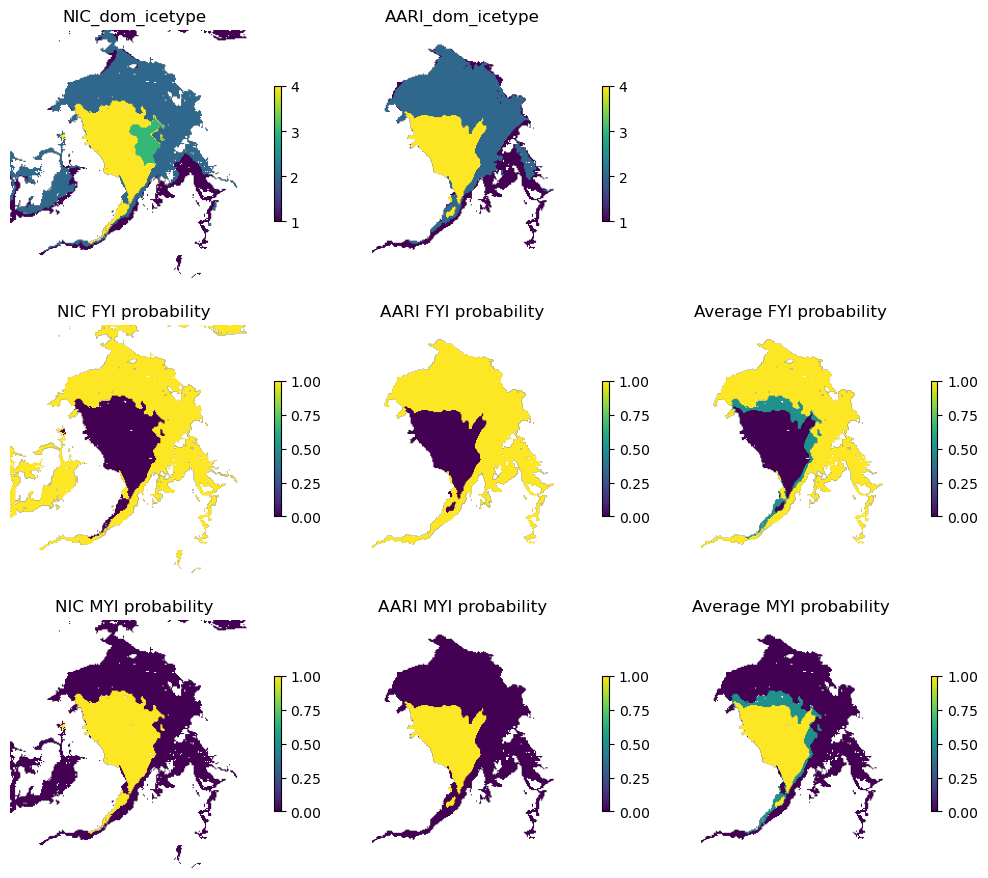

In [4]:
ice_type, proba, date, rf, cf = data_for_plotting
print(rf, cf)
fig, axs = plt.subplots(3, 3, figsize=(10, 9))
for i, name in enumerate(list(ice_type.keys())[:2]):
    img0 = axs[0, i].imshow(ice_type[name])
    axs[0, i].set_title(name)
    axs[1, i].imshow(proba[name][..., 0])
    axs[1, i].set_title(name.split('_')[0]+' FYI probability')
    axs[2, i].imshow(proba[name][..., 1])
    axs[2, i].set_title(name.split('_')[0]+' MYI probability')
    for j in range(3):
        plt.colorbar(axs[j, i].images[0], ax=axs[j, i], shrink=0.5)

axs[1, 2].imshow((proba['NIC_dom_icetype'][..., 0] + proba['AARI_dom_icetype'][..., 0])/2)
axs[1, 2].set_title('Average FYI probability')
axs[2, 2].imshow((proba['NIC_dom_icetype'][..., 1] + proba['AARI_dom_icetype'][..., 1])/2)
axs[2, 2].set_title('Average MYI probability')
for j in range(1, 3):
    plt.colorbar(axs[j, 2].images[0], ax=axs[j, 2], shrink=0.5)
for ax in axs.flat:
    ax.set_axis_off()
plt.tight_layout()
plt.show()

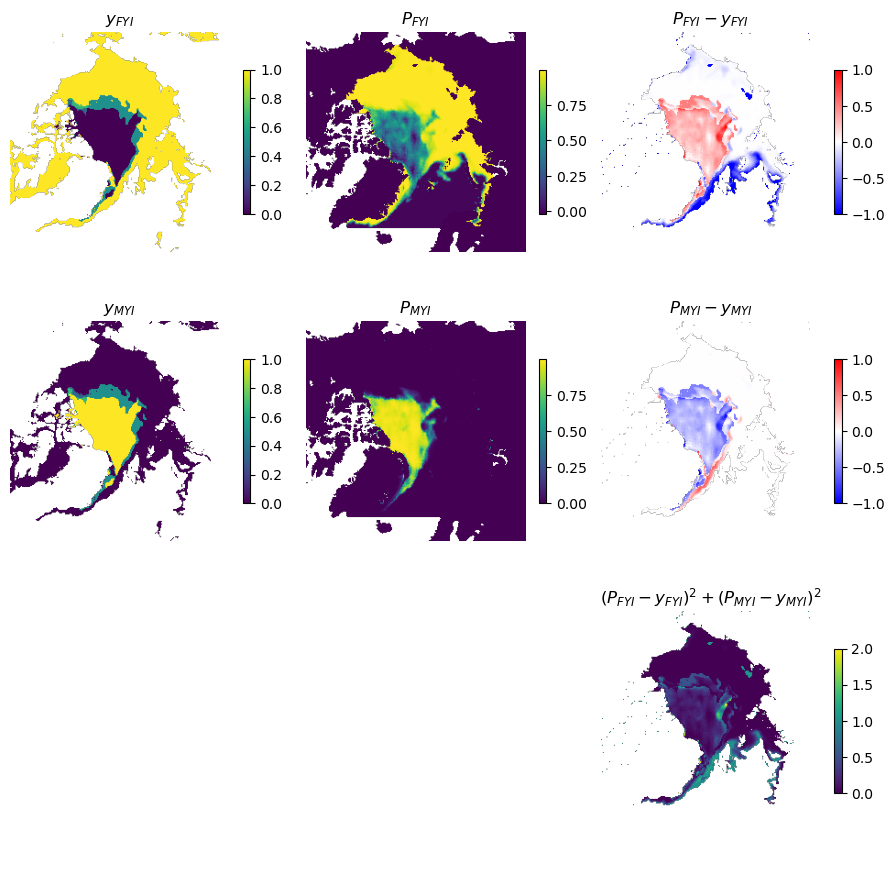

In [5]:
# from comparison of ice charts:
x0_fyi = 0.263
k_fyi = 6.58
x0_myi = 0.423
k_myi = 11.3

proba_lm = np.stack([
    sigmoid(proba['lm'][..., 0], k_fyi, x0_fyi),
    sigmoid(proba['lm'][..., 1], k_myi, x0_myi),
], axis=-1)

fig, axs = plt.subplots(3, 3, figsize=(9, 9))
axs[0, 0].imshow(proba['rrdp'][..., 0])
axs[0, 0].set_title('$y_{FYI}$')

axs[1, 0].imshow(proba['rrdp'][..., 1])
axs[1, 0].set_title('$y_{MYI}$')

#axs[0, 1].imshow(proba['lm'][..., 0])
axs[0, 1].imshow(proba_lm[..., 0])
axs[0, 1].set_title('$P_{FYI}$')

#axs[1, 1].imshow(proba['lm'][..., 1])
axs[1, 1].imshow(proba_lm[..., 1])
axs[1, 1].set_title('$P_{MYI}$')

axs[0, 2].imshow(proba['lm'][..., 0] - proba['rrdp'][..., 0], cmap='bwr', vmin=-1, vmax=1)
axs[0, 2].set_title('$P_{FYI} - y_{FYI}$')

axs[1, 2].imshow(proba['lm'][..., 1] - proba['rrdp'][..., 1], cmap='bwr', vmin=-1, vmax=1)
axs[1, 2].set_title('$P_{MYI} - y_{MYI}$')

proba_diff = np.sum((proba['lm'] - proba['rrdp'])**2, axis=-1)
axs[2, 2].imshow(proba_diff, clim=[0, 2])
axs[2, 2].set_title('$(P_{FYI} - y_{FYI})^2 + (P_{MYI} - y_{MYI})^2$')


for ax in axs.flat:
    ax.set_axis_off()
    if len(ax.images) > 0:
        plt.colorbar(ax.images[0], ax=ax, shrink=0.5)

axs[0, 0].set_ylabel('FYI')
axs[1, 0].set_ylabel('MYI')

plt.tight_layout()
plt.show()
           

In [12]:
min_size = 1000
scores = []
for (date, rf, cf), proba in zip(rrdp_coll_date_files, probas):
    lm_fyi = proba['lm'][..., 0]
    lm_myi = proba['lm'][..., 1]
    
    mask_brier = ((lm_myi + lm_fyi) > 0) & np.isfinite(proba['lm'][..., 0]) & np.isfinite(proba['newdc'][..., 0]) & np.isfinite(proba['nsidc'][..., 0]) & np.isfinite(proba['rrdp'][..., 0])
    count = np.sum(mask_brier)
    if count < min_size:
        continue

    scores_vec = []
    for name in lagr_algos:
        if name == 'lm':
            proba_lm = np.stack([
                sigmoid(proba['lm'][..., 0], k_fyi, x0_fyi),
                sigmoid(proba['lm'][..., 1], k_myi, x0_myi),
            ], axis=-1)
            proba_diff = np.sum((proba_lm - proba['rrdp'])**2, axis=-1)

        proba_diff = np.sum((proba[name] - proba['rrdp'])**2, axis=-1)
        brier = np.nanmean(proba_diff[mask_brier])
        if date >= datetime(2024, 1, 1) and name == 'nsidc':
            brier = np.nan
            
        scores_vec.append(brier)
        
    scores.append((date, *scores_vec, count))

scores = pd.DataFrame(scores, columns=['date', 'B_lm', 'B_newdc', 'B_nsidc', 'count'])
scores.set_index('date', inplace=True)

warnings.filterwarnings('ignore', category=UserWarning)

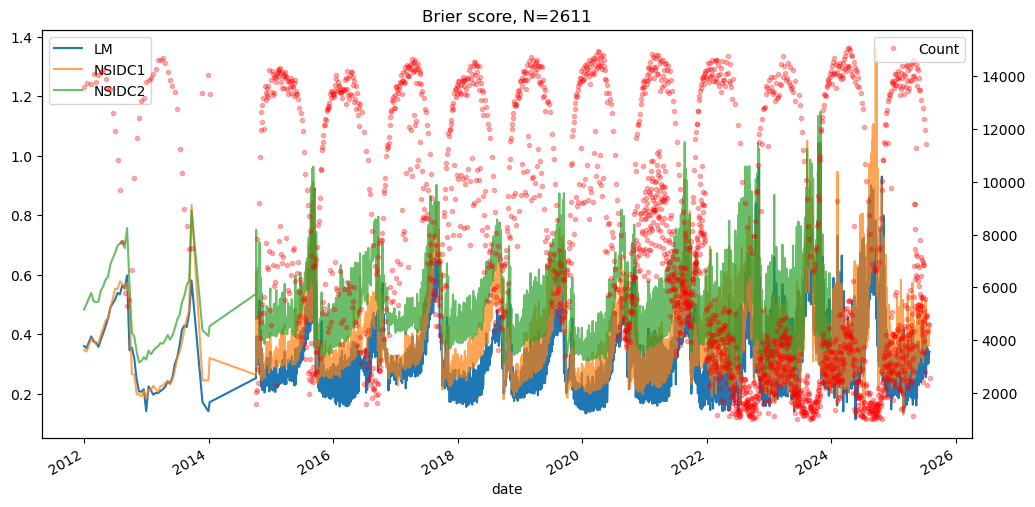

In [16]:
fig = plt.figure(figsize=(12, 6))
scores['B_lm'].plot(label='LM')
scores['B_newdc'].plot(label='NSIDC1', alpha=0.7)
scores['B_nsidc'].plot(label='NSIDC2', alpha=0.7)
#plt.ylim(0.5, 1)
plt.legend(loc='upper left')
ax2 = plt.twinx()
ax2.plot(scores.index, scores['count'].values, 'r.', label='Count', alpha=0.3)
plt.legend(loc='upper right')
plt.title(f'Brier score, N={scores.shape[0]}')
plt.show()

In [15]:
scores['B_lm'].mean(), scores['B_newdc'].mean(), scores['B_nsidc'].mean()

(np.float64(0.33819904413397534),
 np.float64(0.40062255657880763),
 np.float64(0.521085213884059))